In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models (DDPM) with miniai

## Imports

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load dataset

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
dt = dls.train
xb, yb = next(iter(dt))

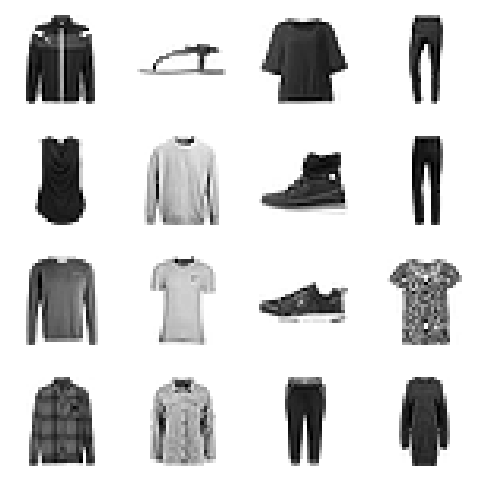

In [5]:
show_images(xb[:16], imsize=1.5)

## Parameters of the DDPM

In [7]:
# from "4. Experiments" in https://arxiv.org/pdf/2006.11239.pdf
beta_min, beta_max, n_steps = 0.0001, 0.02, 1000

# FORWARD PROCESS
"""We set the forward process variances to constants 
# increasing linearly from β1 = 10−4 to βT = 0.02."""
beta = torch.linspace(beta_min, beta_max, n_steps)

"""A notable property of the forward process is that it admits sampling xt at an
arbitrary timestep t in closed form: using the notation αt := 1 − βt and ¯αt := ∏t
s=1 αs"""
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

"""Experimentally, both σ2t = βt and σ2t = ˜βt = 1− ¯αt−1 1− ¯αt βt had similar results"""
sigma = beta.sqrt()